# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18,norm='l1',alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
            
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
       
    
    # Add another vectorized set of words, but this time add ngrams
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 18,strip_accents='ascii',stop_words='english',ngram_range=(1, 1),alternate_sign=False)
        hv2 = HashingVectorizer(n_features=2 ** 18,ngram_range=(1, 5),norm='l1',analyzer='word',stop_words="english",tokenizer=LemmaTokenizer(),alternate_sign=False)
        X_hv2 = hv2.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv2)
        print("Shape of HashingVectorizer X:")
        print(X_hv2.shape)
    else: # transform() 
        X_hv2 = fitted_transformations[2].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv2.shape)
    
    
    
#     # Add letter ngrams
#     if (not test): # fit_transform()
# #         hv = HashingVectorizer(n_features=2 ** 18,strip_accents='ascii',stop_words='english',ngram_range=(1, 1),alternate_sign=False)
#         hv3 = HashingVectorizer(n_features=2 ** 18,ngram_range=(3, 6),analyzer='char_wb',alternate_sign=False)
#         X_hv3 = hv.fit_transform(toxic_data.comment_text)
#         fitted_transformations.append(hv3)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv3.shape)
#     else: # transform() 
#         X_hv3 = fitted_transformations[3].transform(toxic_data.comment_text)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv3.shape)
    
    
    
    
    
    # create additional quantitative features
    # count punctuation
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count1'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\?")
    # count uppercase letters
    # https://stackoverflow.com/questions/18129830/count-the-uppercase-letters-in-a-string-with-python
    toxic_data['uppc_count'] = len(re.findall(r'/([A-Z]){3,}/',str(toxic_data['comment_text'])))

        
    X_quant_features = toxic_data[["word_count", "punc_count1","punc_count2","punc_count3"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))

#     X_quant_features = toxic_data[["word_count", "punc_count"]]
#     print("Look at a few rows of the new quantitative features: ")
#     print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_hv2,  X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[3].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=555)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

C:\Users\antho\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Shape of HashingVectorizer X:
(159571, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count1  punc_count2  punc_count3
0          42            5            0            1
1          18            2            1            0
2          42            3            0            0
3         112            3            0            0
4          13            1            0            1
5          12            1            0            0
6           8            0            0            0
7          21            2            0            0
8          83            7            0            1
9          12            0            0            0
Size of combined bag of words and new quantitative variables matrix:
(159571, 524292)
(159571, 524292)
Shape of X_train and X_test:
(127656, 524292)
(31915, 524292)
Shape of y_train and y_test:
(127656,)
(31915,)
Shape of X_raw_train and X_raw_test:
(127656, 14)
(31915, 14)
SUCCESS!
Number of fits stored in `fitted

# Fit (and tune) Various Models

In [5]:
### MODEL: ordinary least squares

# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

In [6]:
# MODEL: SVM, linear
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12969, 'TN': 114670, 'FP': 9, 'FN': 8, 'Accuracy': 0.9998668296045623, 'Precision': 0.9993065187239945, 'Recall': 0.9993835246975418, 'desc': 'svm_train'}


In [7]:
# MODEL: logistic regression

from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',penalty='l1',alpha=0.0002)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12246, 'TN': 114286, 'FP': 393, 'FN': 731, 'Accuracy': 0.9911950867957636, 'Precision': 0.9689057678613814, 'Recall': 0.9436695692378824, 'desc': 'lgs_train'}


C:\Users\antho\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [8]:
# MODEL: Naive Bayes
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB
# from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
# nbs = MultinomialNB()
nbs = ComplementNB(alpha=30,norm=True)

nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 8966, 'TN': 114539, 'FP': 140, 'FN': 4011, 'Accuracy': 0.9674829228551732, 'Precision': 0.9846255216340875, 'Recall': 0.6909146952300224, 'desc': 'nbs_train'}


In [9]:
# MODEL: Perceptron

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',penalty='elasticnet')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12965, 'TN': 114671, 'FP': 8, 'FN': 12, 'Accuracy': 0.9998433289465438, 'Precision': 0.9993833346180528, 'Recall': 0.9990752870463127, 'desc': 'prc_train'}


In [10]:
# MODEL: Ridge Regression Classifier

from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=5)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12966, 'TN': 111541, 'FP': 3138, 'FN': 11, 'Accuracy': 0.975332142633327, 'Precision': 0.8051415797317437, 'Recall': 0.99915234645912, 'desc': 'rdg_train'}


In [11]:
# MODEL: Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

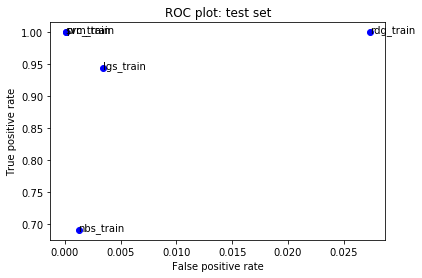

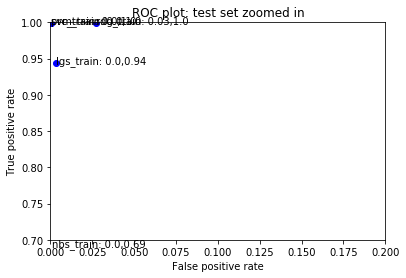

In [12]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits = [ svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set zoomed in')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
# ols_predictions = ols.predict(X_train)
# svm_predictions = svm.predict(X_train)
# lgs_predictions = lgs.predict(X_train)
# the_preds = nbs.predict(X_train)
# prc_predictions = prc.predict(X_train)
the_preds = rdg.predict(X_train)

In [14]:
# let's look at some false positives:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
70
ho ho ho yo 

So why dont you actually contribute something to wikipedia yourself instead of checking, controlling and constantly reading what others are doing?? You dont have the intellectual capacity or the depth, huh? Or do you simply lack a life so much that virtual vandal patrolling is the most interesting thing that you do during the day??!! In either case, do know that I will be praying for you and your poor soul...
* * * * * * * * * 
409
"""This user prefers warm weather and has a great tan.""

Oh baby, I want to lick all that tan make it all white again. I want to get dirty in your juices and and want you to get dirty in mine. hehe. 
Baby don't come between me and Edgar. You are a baby gal, aint you?

"
* * * * * * * * * 
549
YOU STILL REFUSE TO DO ANYTHING ABOUT THE VANDAL I WAS REVERTING!!!!!!
* * * * * * * * * 
3908
Who are you?  Are you the Wikipedia police? I would like to speak to you over the phone or in person.

Your Danish Meta Study ha

30450
Before Attitude Increases due to lack of Blood in Brain 

Whatever your personal feelings you are nothing more than a communist who want to own your own board and are using illicit tactics.  I have been on the net for over a decade and have seen a lot of attitude, and you need to take your attitude home and understand that in the United States of America your way of life is based upon despots, censorship, and hate.  Moron.  The subject is Heaven and you believe God has no part of Heaven.  Does your friends know what kind of anti-faith atheist you are in  a public message board?  Please tell me you are someone who swore an oath to the Constitution for the United States, since you would believe in your little power plays versus actual faith and truth in the source of the American Way of Life.
* * * * * * * * * 
32785
"
And you can't do this because? What's wrong with your fingers?  TALK! "
* * * * * * * * * 
32945
"

 Give a reason when you accuse someone of vandalism 
I got a mess

45191
Speaking without knowing what I'm talking about? OK, how 'bout this: the original comment I made about Everlast's entry constantly being vandalized by Eminem fans was written a month ago before your dumb ass got involved with the site. The feud started with the Dilated Peoples track. That's why I believed that the verse Everlast contributed should be in there (and still do). The jabs taken back and forth after that deserve a synopsis only. Your idiotic little comment about album sales was excessive and unnecessary. It belongs in there no more than the fact that everyone who knows both artists agrees that if they ever got into it, Everlast would knock the living shit outta Eminem. And THAT came off an Eminem fan site.
* * * * * * * * * 
45204
references to kool g rap 

should there be a section for references to kool g rap e.g. the games song westside story?
* * * * * * * * * 
45718
People like you 359 take he virtual world way too seriously. You are obviously trying to make up fo

64417
.
oh, leave me alone ;)
* * * * * * * * * 
64474
"To Example Number Three: 

First that was direct ed to gareth and amy who tell autistics they agree with me that cure is genocide. Second it is not flaming if it is true.Joe Mele

OK well there is a movement afoot here and else where to silence a particular point of view held by many aspergians. Silence=Death. There will be no cure, If there is ever a half ass prenatal test, it will be resisted by any means necessary by the majority. Most aspies that want a cure are just horny looking for a  girlfriend. Joe Mele

In response to paragraph one: Yes it is flaming. Calling someone a backstabber is undeniably flaming. It is a personal attack, which you have made AGAIN, by saying ""it (the backstabbing accusation) is true""
In response to paragraph two: You are starting to sound disturbingly like Tern here. 
 

"
* * * * * * * * * 
64896
The accusations and lies continue on his page. I highly suggest you get the Checkuser nobody has con

89047
oh! 

so you're a radio DJ now?  That's awesome!  And whats up with all the racial slurs on your user page my man?  wha??
* * * * * * * * * 
89315
"*LoL @ ""connection to Obama"". Here' what Obama Really thinks of Cuba:

""Throughout my entire life, there has been injustice and repression in Cuba. Never, in my lifetime, have the people of Cuba known freedom. Never, in the lives of two generations of Cubans, have the people of Cuba known democracy. (...) This is the terrible and tragic status quo that we have known for half a century - of elections that are anything but free or fair (...) I won't stand for this injustice, you won't stand for this injustice, and together we will stand up for freedom in Cuba,""

Any so-called leftist-revolutionary who thinks Obama will be any different from whitey is simply deluding themselves. He's in fact, a great tool for the bourgeoisie to fool revolutionaries from all communities. Isabel is just some dumb wannabe commie who jumped on the Obama 

114447
look guys i like jews as much as the next guy and im not gunna edit things anymore. i just want the priveledge back.  i dunno what i'm liable to do if i cant edit WIKIPEDIA PAGES!!!!!!
* * * * * * * * * 
114597
Maybe Crossmr should not be removing large portions of discussion with no discussion. Improper, irresponsible, arrogant, and just plain wrong. Crossmr is guilty of this over many articles. I guess if you disagree with Crossmr, your opinion / position / comments / discussion just don't count.
* * * * * * * * * 
116479
yeah, i already took it out.  started to notice it looked kind of funny.  btw, who are you people?  you're scaring me.  ;)  Gocashiers
* * * * * * * * * 
116603
Just don't let it go to your head. P
* * * * * * * * * 
117360
American who hates Australia 
I have seen on several Australian pages where YOU have said some pretty awful and offensive things about my country. If you hate Australia thats fine, but I would like you to keep it to yourself.
If you want t

In [15]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false negatives:
42334
WELCOME, BITCH

Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!
* * * * * * * * * 
45294
"
 The various local government areas pages only list them.  I was thinking something like that.  These three paragraphs are from a couple of papers I wrote, they can be incorporated into the article.  

The states (and territories) run the majority of the government in Australia and d

101629
I have no idea why you are posting the slang definitions of 'fuck'.  That is a total non-sequitur.  I have not seen anyone here assert that there aren't any ways of using 'fuck' that are slang.  The point was, and remains, that the standard use of the word 'fuck' as both a noun and a verb - the only ways that this word has been used in this entire discussion throughout this entire week up until your latest post - has been the standard definition that is widely understood and accepted as a normal word that is nowhere near slang.

You used this non-sequitur as your basis for reversion.  And to this day you are persisting in it.  Yet again another example of a huge logic disconnect that permeates this entire exchange.

As for the meta-discussion (the discussion about the discussion), Andy's revert was based upon his assessment that the issue needed to be discussed before such a change could be accepted.  And where did he choose to raise that discussion?  Over on my User Talk page. 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [16]:
# MODEL: ordinary least squares
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

In [17]:
# MODEL: SVM, linear
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1638, 'TN': 27744, 'FP': 923, 'FN': 1610, 'Accuracy': 0.9206329312235626, 'Precision': 0.6395939086294417, 'Recall': 0.5043103448275862, 'desc': 'svm_test'}


In [18]:
# MODEL: logistic regression
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1730, 'TN': 25891, 'FP': 2776, 'FN': 1518, 'Accuracy': 0.8654551151496161, 'Precision': 0.38393253439857966, 'Recall': 0.5326354679802956, 'desc': 'lgs_test'}


In [19]:
# MODEL: Naive Bayes
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 526, 'TN': 28315, 'FP': 352, 'FN': 2722, 'Accuracy': 0.9036816543944853, 'Precision': 0.5990888382687927, 'Recall': 0.16194581280788178, 'desc': 'nbs_test'}


In [20]:
# MODEL: Perceptron
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1799, 'TN': 27717, 'FP': 950, 'FN': 1449, 'Accuracy': 0.9248315838947203, 'Precision': 0.654419789014187, 'Recall': 0.5538793103448276, 'desc': 'prc_test'}


In [21]:
# MODEL: Ridge Regression Classifier
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 2882, 'TN': 24921, 'FP': 3746, 'FN': 366, 'Accuracy': 0.8711577628074573, 'Precision': 0.4348219674109837, 'Recall': 0.8873152709359606, 'desc': 'rdg_test'}


In [22]:
# MODEL: Random Forest Classifier
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

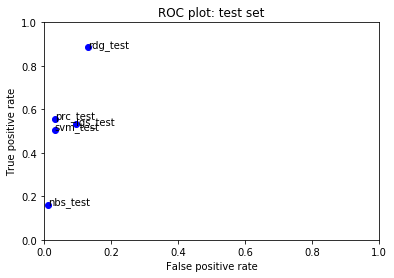

In [23]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test,  nbs_performance_test,  rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
    
# # plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.4, 1])
# plt.title('ROC plot: test set zoomed in')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=555, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 262144)


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# my_submission["prediction"] = svm.predict(X_test_submission)
# my_submission["prediction"] = lgs.predict(X_test_submission)
# my_submission["prediction"] = prc.predict(X_test_submission)
my_submission["prediction"] = rdg.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
# my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)
my_submission.to_csv('../final_data/toxiccomments_submission_final.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation